Below is summary of data schema - 
![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv('../input/application_train.csv', usecols=['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH','AMT_CREDIT','AMT_INCOME_TOTAL','AMT_ANNUITY','DAYS_EMPLOYED'])

In [4]:
train_data.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,202500.0,406597.5,24700.5,-9461,-637,0.083037,0.262949,0.139376
1,0,270000.0,1293502.5,35698.5,-16765,-1188,0.311267,0.622246,NaN
2,0,67500.0,135000.0,6750.0,-19046,-225,NaN,0.555912,0.729567
3,0,135000.0,312682.5,29686.5,-19005,-3039,NaN,0.650442,NaN
4,0,121500.0,513000.0,21865.5,-19932,-3038,NaN,0.322738,NaN


There is lot of missing values in dataframe which will have to be filled to properly train model on it.

In [5]:
train_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Hence no. of loan that were repaid were far greater than loans that were not repayed hence dataset is not exactly balanced.

Next we have to deal with catagorical data so we have to perform encoding i.e. convert text type labels into numerical labels using scikit-learn's default label encoder

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()
j = 0
for column in train_data:
    if train_data[column].dtype == 'object':
        if len(list(train_data[column].unique())) <= 2:
            le.fit(train_data[column])
            train_data[column] = le.transform(train_data[column])
            j += 1
print(str(j) + ' Columns encoded')

0 Columns encoded


so LabelEncoder was useless so trying one hot encoding

In [8]:
train_data = pd.get_dummies(train_data)
train_data.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,1,202500.0,406597.5,24700.5,-9461,-637,0.083037,0.262949,0.139376
1,0,270000.0,1293502.5,35698.5,-16765,-1188,0.311267,0.622246,NaN
2,0,67500.0,135000.0,6750.0,-19046,-225,NaN,0.555912,0.729567
3,0,135000.0,312682.5,29686.5,-19005,-3039,NaN,0.650442,NaN
4,0,121500.0,513000.0,21865.5,-19932,-3038,NaN,0.322738,NaN


That was usefull !. Now trying to find correlations in the data

In [9]:
correlations = train_data.corr()['TARGET']

In [10]:
correlations.sort_values(ascending=False)

TARGET              1.000000
DAYS_BIRTH          0.078239
AMT_INCOME_TOTAL   -0.003982
AMT_ANNUITY        -0.012817
AMT_CREDIT         -0.030369
DAYS_EMPLOYED      -0.044932
EXT_SOURCE_1       -0.155317
EXT_SOURCE_2       -0.160472
EXT_SOURCE_3       -0.178919
Name: TARGET, dtype: float64

In [11]:
train_data['DAYS_BIRTH'].corr(train_data['TARGET'])

0.07823930830982694

It is apparant that DAYS_BIRTH which is days since birth is highly correlated implying that as person gets older he is less likely to default on loan. But this correlation is negative so as person gets older he is less likely to default on loan

EXT_SOURCE# Seem to be highly negatively correlated but very non-descript

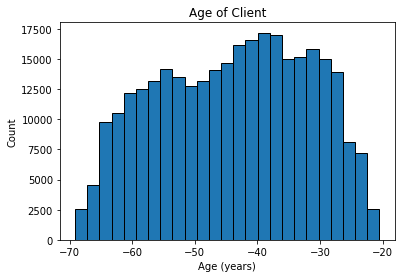

In [12]:
plt.hist(train_data['DAYS_BIRTH']/365, edgecolor='k', bins=25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

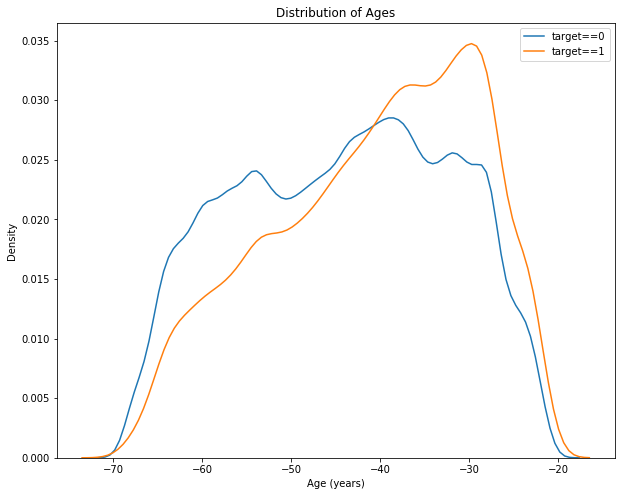

In [13]:
plt.figure(figsize=(10,8))

sns.kdeplot(train_data.loc[train_data['TARGET'] == 0, 'DAYS_BIRTH']/365, label='target==0')
sns.kdeplot(train_data.loc[train_data['TARGET'] == 1, 'DAYS_BIRTH']/365, label='target==1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

As is evident from above Curve for default (target == 0) is skewed towards younger side of ages

Exploring the EXT SOURCES using seaborn correlation heatmaps

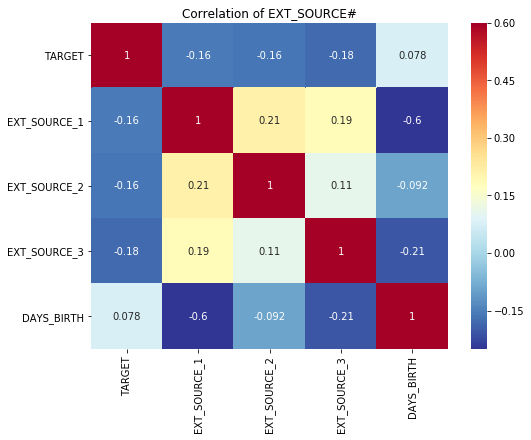

In [14]:
ext_data_corrs = train_data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr()
plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation of EXT_SOURCE#');

# Domain Features made by researching on internet

In [8]:
train_data['CREDIT_INCOME_PERCENT'] = train_data['AMT_CREDIT'] / train_data['AMT_INCOME_TOTAL']
train_data['ANNUITY_INCOME_PERCENT'] = train_data['AMT_ANNUITY'] / train_data['AMT_INCOME_TOTAL']
train_data['CREDIT_TERM'] = train_data['AMT_ANNUITY'] / train_data['AMT_CREDIT']
train_data['DAYS_EMPLOYED_PERCENT'] = train_data['DAYS_EMPLOYED'] / train_data['DAYS_BIRTH']

1. ALL the EXT_SOURCES Are negatively correlated to loan default

# Imputing missing values by default mean method

In [9]:
from sklearn.impute import SimpleImputer
X = train_data.drop('TARGET',axis=1)
list_of_features = X.columns
Y = train_data['TARGET']

imputer = SimpleImputer()

X = pd.DataFrame(imputer.fit_transform(X))
X.columns = list_of_features
X.shape

(307511, 12)

In [12]:
Y.name = 'TARGET'
graph_data = pd.concat([X,Y], axis=1)

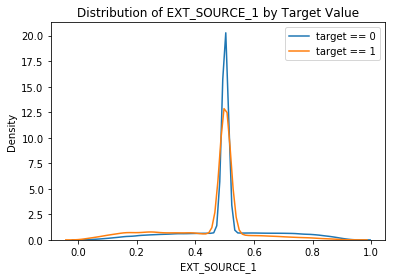

In [12]:
sns.kdeplot(graph_data.loc[graph_data['TARGET'] == 0, 'EXT_SOURCE_1'], label = 'target == 0')
sns.kdeplot(graph_data.loc[graph_data['TARGET'] == 1, 'EXT_SOURCE_1'], label = 'target == 1')
plt.title('Distribution of EXT_SOURCE_1 by Target Value')
plt.xlabel('EXT_SOURCE_1'); 
plt.ylabel('Density');

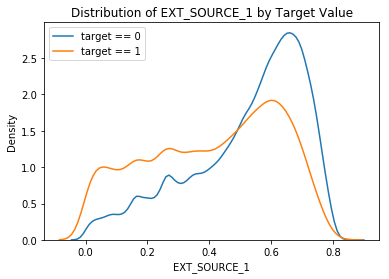

In [13]:
sns.kdeplot(graph_data.loc[graph_data['TARGET'] == 0, 'EXT_SOURCE_2'], label = 'target == 0')
sns.kdeplot(graph_data.loc[graph_data['TARGET'] == 1, 'EXT_SOURCE_2'], label = 'target == 1')
plt.title('Distribution of EXT_SOURCE_1 by Target Value')
plt.xlabel('EXT_SOURCE_1'); 
plt.ylabel('Density');

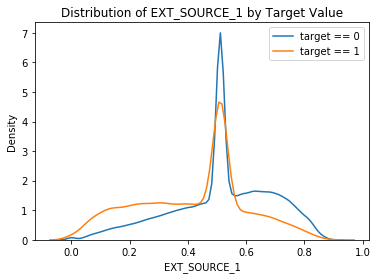

In [14]:
sns.kdeplot(graph_data.loc[graph_data['TARGET'] == 0, 'EXT_SOURCE_3'], label = 'target == 0')
sns.kdeplot(graph_data.loc[graph_data['TARGET'] == 1, 'EXT_SOURCE_3'], label = 'target == 1')
plt.title('Distribution of EXT_SOURCE_1 by Target Value')
plt.xlabel('EXT_SOURCE_1'); 
plt.ylabel('Density');

EXT_SOURCE_3 displays the greatest difference between the values of the target

# Machine Learning Models Code

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [13]:
def print_metrics(y_test,predictions,model):
    print('\033[1m' + model + '\033[0m' + '\n\n')
    print('\033[1m' + 'Classification Report - ' + '\033[0m')
    print(classification_report(y_test,predictions))
    print('\033[1m' + 'ROC AUC Score - ' + '\033[0m')
    print(roc_auc_score(y_test,predictions))
    print('\033[1m' + 'Accuracy Score - ' + '\033[0m')
    print(accuracy_score(y_test,predictions))
    
    

def dtree(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    predictions_dt = dt.predict(X_test)
    print_metrics(y_test,predictions_dt,'Decision Tree')
    
def xboost(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    boost = XGBClassifier(eval_metric='auc')
    boost.fit(X_train,y_train)
    predictions_boost = boost.predict(X_test)
    print_metrics(y_test,predictions_boost,'XGBoost')
    
def rforrest(X,y,n):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    rfc = RandomForestClassifier(n_estimators=n,n_jobs=-1)
    rfc.fit(X_train,y_train)
    predictions_rfc = rfc.predict(X_test)
    print_metrics(y_test,predictions_rfc,'Random Forrest')
    
def nbayes(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    nb = GaussianNB()
    nb.fit(X_train,y_train)
    predictions_nb = nb.predict(X_test)
    print_metrics(y_test,predictions_nb,'Naive Bayes')

In [14]:
xboost(X,Y)

XGBoost


Classification Report - 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84841
           1       0.55      0.01      0.01      7413

   micro avg       0.92      0.92      0.92     92254
   macro avg       0.74      0.50      0.48     92254
weighted avg       0.89      0.92      0.88     92254

ROC AUC Score - 
0.5027555977688726
Accuracy Score - 
0.9197324777245431


In [15]:
dtree(X,Y)

Decision Tree


Classification Report - 
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     84841
           1       0.15      0.17      0.16      7413

   micro avg       0.85      0.85      0.85     92254
   macro avg       0.54      0.54      0.54     92254
weighted avg       0.86      0.85      0.86     92254

ROC AUC Score - 
0.5429792387147511
Accuracy Score - 
0.8524183233247339


In [16]:
rforrest(X,Y,500)

Random Forrest


Classification Report - 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84841
           1       0.49      0.01      0.03      7413

   micro avg       0.92      0.92      0.92     92254
   macro avg       0.71      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254

ROC AUC Score - 
0.5060147783635576
Accuracy Score - 
0.9196132417022568
